# Montu Python 
## Astronomical ephemerides for the Ancient World
## Example: Venus Azimutal Distributions


### Goals of this notebook

The goal of this notebook is to compute the distribution of Venus azimuths at dawn. 

In [1]:
# Uncomment this line in Colab
# !pip install -q montu; mkdir -p montmp/

### Loading tools

We need to load the packages and the required data for it (star database, planet position database, etc.):

In [1]:
# Montu packages and data
import montu
from montu import D2H, PRINTDF, TABLEDF, DEG, RAD

# Other libraries required
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np

# Load allstars
allstars = montu.Stars()

# These magic commands are intended to allow updating the packages if they change
%load_ext autoreload
%autoreload 2

Running MontuPython version 0.9.1


### Venus appearances

Lets set observing conditions and initial time of exploration:

In [2]:
Tebas = montu.Observer(lon=33,lat=24,height=0)

Our target body:

In [3]:
venus = montu.Planet('Venus')
sun = montu.Sun()

Now let's compute the conditions of observation of Venus for a given date:

In [210]:
mtime = montu.Time('-300-12-04 12:00:00')
#mtime = montu.Time()
print(f"Conditions for Venus observations at {mtime.readable.datemix}")
print('='*80)

# Compute Venus condition
venus.conditions_in_sky(at=mtime,observer=Tebas)

# Compute Sun conditions
sun.conditions_in_sky(at=mtime,observer=Tebas)
print("Sun rise time:",Tebas.get_local_time(sun.condition.rise_time))
print("Sun set time:",Tebas.get_local_time(sun.condition.set_time))
print()

dusk_time,dawn_time = montu.Sun.when_is_twilight(day=mtime,observer=Tebas,sunbelow=-18)
print("Time when dawn twilight ends: ",Tebas.get_local_time(dawn_time))
print("Time when dusk twilight starts: ",Tebas.get_local_time(dusk_time))
print()

print("Venus rise time:",Tebas.get_local_time(venus.condition.rise_time))
print("Venus set time:",Tebas.get_local_time(venus.condition.set_time))
print()

# Determine if it will be visible at dawn or dusk
mtime_obs = None
print("Visibility conditions:")
if venus.condition.set_time > sun.condition.set_time:
    print("\tVisible at dawn")
    
    # Determine if it will be visible when twilight has ended
    if venus.condition.set_time > dawn_time:
        print("\t\tVisible after dawn twilight ends")
        mtime_obs = montu.Time(dawn_time,format='jd')
        state = 'dawn'

elif venus.condition.rise_time < sun.condition.rise_time:
    print("\tVisible at dusk")

    # Determine if it will be visible when twilight has ended
    if venus.condition.rise_time < dusk_time:
        print("\t\tVisible before dusk twilight start")
        mtime_obs = montu.Time(dusk_time,format='jd')
        state = 'dusk'
else:
    print("Venus is transiting the Sun")

print()
if mtime_obs:
    venus.conditions_in_sky(at=mtime_obs,observer=Tebas)
    print(f"Venus position at {state}:")
    print(f"\tAz,el: {D2H(venus.position.az)}, {D2H(venus.position.el)}")
    print(f"\tMagnitude: {venus.condition.Vmag}")


Conditions for Venus observations at -300-12-08 12:00:00
Sun rise time: 06:36:0.754
Sun set time: 17:15:52.606

Time when dawn twilight ends:  18:37:41.649
Time when dusk twilight starts:  05:14:12.457

Venus rise time: 03:07:15.823
Venus set time: 14:43:11.671

Visibility conditions:
	Visible at dusk
		Visible before dusk twilight start

Venus position at dusk:
	Az,el: 113:42:36.443, 27:17:16.877
	Magnitude: -4.14


Let's do it for many dates during a whole Synodic period:

In [267]:
mtime_initial = montu.Time('-3000-01-01 12:00:00')

venus_conditions = []
for dt in montu.PROGRESS(
    montu.Util.arange(0,4*montu.ALLPLANETS.loc['Venus','SynodicOrbit']*montu.YEAR,1*montu.DAY)
    ):
    
    mtime = mtime_initial + dt

    # Compute Sun conditions
    sun.conditions_in_sky(at=mtime,observer=Tebas)
    dusk_time,dawn_time = montu.Sun.when_is_twilight(day=mtime,observer=Tebas,sunbelow=-18)

    # Compute Venus condition
    venus.conditions_in_sky(at=mtime,observer=Tebas)

    # Conditions
    visible_at_dawn = False
    visible_at_dusk = False
    visible_before_dusk = False
    visible_after_dawn = False

    # Determine if it will be visible at dawn or dusk
    mtime_obs = None
    az_horizon = 361
    if venus.condition.set_time > sun.condition.set_time:
        visible_at_dawn = True
        az_horizon = venus.condition.set_az    
        # Determine if it will be visible when twilight has ended
        if venus.condition.set_time > dawn_time:
            visible_after_dawn = True
            mtime_obs = montu.Time(dawn_time,format='jd')
            state = 'dawn'

    elif venus.condition.rise_time < sun.condition.rise_time:
        visible_at_dusk = True
        az_horizon = venus.condition.rise_az
        # Determine if it will be visible when twilight has ended
        if venus.condition.rise_time < dusk_time:
            visible_before_dusk = True
            mtime_obs = montu.Time(dusk_time,format='jd')
            state = 'dusk'
    else:
        pass

    az_twilight = None
    el_twilight = None
    if mtime_obs:
        venus.conditions_in_sky(at=mtime_obs,observer=Tebas)
        az_twilight = venus.position.az
        el_twilight = venus.position.el

    venus_conditions += [dict(
        jed = mtime.jed,
        sun_rise_time = sun.condition.rise_time,
        sun_set_time = sun.condition.set_time,
        dusk_time = dusk_time,
        dawn_time = dawn_time,
        venus_rise_time = venus.condition.rise_time,
        venus_set_time = venus.condition.set_time,
        visible_at_down = visible_at_dawn,
        visible_after_dawn = visible_after_dawn,
        visible_at_dusk = visible_at_dusk,
        visible_before_dusk = visible_before_dusk,
        az_horizon = az_horizon,
        az_twilight = az_twilight,
        el_twilight = el_twilight,
    )]
mtime_final = mtime.get_readable()
venus_conditions = pd.DataFrame(venus_conditions)

# Save data
suffix = f'{abs(mtime_initial.readable.year)}'
venus_conditions.to_csv(f'montmp/venus-conditions-year_{suffix}_bce.csv')

  0%|          | 0/2336 [00:00<?, ?it/s]

100%|██████████| 2336/2336 [00:13<00:00, 172.46it/s]


Exclude problematic conditions:

In [268]:
cond = (venus_conditions.az_twilight == 361)|(venus_conditions.az_horizon == 361)
venus_conditions = venus_conditions[~cond]

Plot conditions:

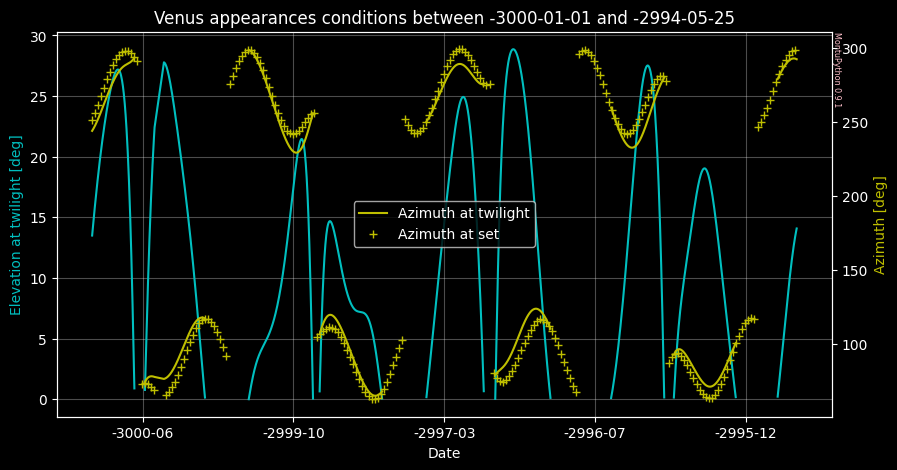

In [269]:
with plt.style.context('dark_background'):
    fig,ax_el = plt.subplots(figsize=(10,5))
    ax_az = ax_el.twinx()
    
    ax_el.plot(venus_conditions.jed,venus_conditions.el_twilight,'c')
    
    ax_az.plot(venus_conditions.jed,venus_conditions.az_twilight,'y',label='Azimuth at twilight')
    ax_az.plot(venus_conditions.jed[::10],venus_conditions.az_horizon[::10],'y+',label='Azimuth at set')

    # Decorate
    montu.Time.set_time_ticks(ax_el,format='jd',timefmt='%Y-%m',fontsize=10)
    ax_el.set_xlabel('Date')
    ax_el.set_ylabel('Elevation at twilight [deg]',color='c')
    ax_az.set_ylabel('Azimuth [deg]',color='y')
    ax_az.legend(loc='center')

    ax_el.set_title(f"Venus appearances conditions between {mtime_initial.strftime('%Y-%m-%d')} and {mtime_final.strftime('%Y-%m-%d')}")
    ax_el.grid(alpha=0.3)
    montu.Util.montu_mark(ax_el);
    fig.savefig(f'montmp/venus-appearances-year_{suffix}_bce.png')

Histogram of azimuths:

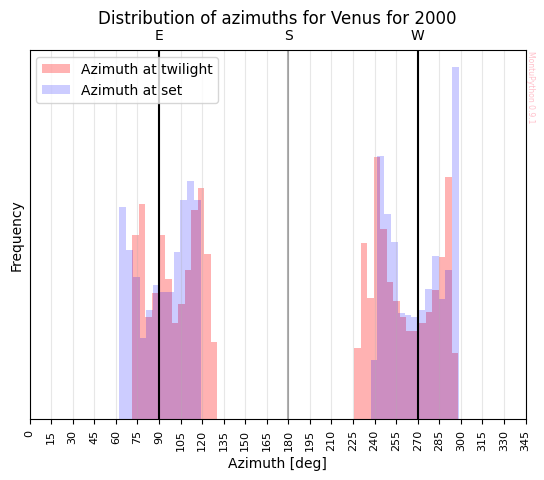

In [264]:
fig,ax = plt.subplots()

hs,xs,bs = ax.hist(
    venus_conditions.az_twilight,
    bins=50,density=True,
    color='r',alpha=0.3,
    label = 'Azimuth at twilight'
    )

hs,xs,bs = ax.hist(
    venus_conditions.az_horizon,
    bins=50,density=True,
    color='b',alpha=0.2,
    label = 'Azimuth at set'
    )

hmax = hs.max()
# vertical bars
ax.axvline(90,color='k')
ax.text(90,1.08*hmax,'E',ha='center')
ax.axvline(180,color='k',alpha=0.3)
ax.text(180,1.08*hmax,'S',ha='center')
ax.axvline(270,color='k')
ax.text(270,1.08*hmax,'W',ha='center')

ax.set_xticks(np.arange(0,360,15))
ax.tick_params(axis='x',which='major',labelsize=8,rotation=90)
ax.set_yticks([])

ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of azimuths for Venus for {suffix}',x=0.5,y=1.05)

montu.Util.montu_mark(ax);
fig.savefig(f'montmp/venus-appearances-distribution-year_{suffix}_bce.png')

## Complimentary

In [ ]:
suffix=2000
exec(f"venus_conditions = venus_conditions_{suffix}")
cond = (venus_conditions.az_twilight>270) & (venus_conditions.az_twilight<360) 
print(f"Azimutes en -{suffix}, crepúsculo, puesta: {max(venus_conditions[cond].az_twilight)},{max(venus_conditions[cond].az_horizon)}")

suffix=3000
exec(f"venus_conditions = venus_conditions_{suffix}")
cond = (venus_conditions.az_twilight>270) & (venus_conditions.az_twilight<360) 
print(f"Azimutes en -{suffix}, crepúsculo, puesta: {max(venus_conditions[cond].az_twilight)},{max(venus_conditions[cond].az_horizon)}")

Azimutes en -2000, crepúsculo, puesta: 297.96746699466985,299.3237239977809
Azimutes en -3000, crepúsculo, puesta: 298.13483395009183,299.01346948492227


The end!